In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
# # Define the initial belief calculation function based on sophistication level
# def initial_belief_function(node, G, sophistication_levels):
#     neighbors = list(G.neighbors(node))
#     if len(neighbors) == 0:
#         return np.random.rand()  # If no neighbors, assign a random initial belief
#     else:
#         player_level = sophistication_levels[node]
#         mapped_levels = [min(player_level - 1, sophistication_levels[neighbor]) for neighbor in neighbors]
#         return np.mean(mapped_levels)  # Average over mapped sophistication levels




# # Define parameters
# num_players = 1000
# k_max = 10

# # Determine the number of step-0 thinkers (1 percent of players)
# num_step_0 = int(0.05 * num_players)

# # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
# sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# # Add step-0 thinkers to the sophistication levels
# sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
# np.random.shuffle(sophistication_levels)

# # Initialize lists to store results and labels for the different network types
# network_types = ['ER Graph', 'Newman-Watts-Strogatz Graph', 'Barabási-Albert Graph', 'Configuration Model']
# results = []
# mse_values = []

# # Generate and evaluate beliefs for each network type
# for network_type in network_types:
#     if network_type == 'ER Graph':
#         G = nx.erdos_renyi_graph(num_players, 0.2)
#     elif network_type == 'Newman-Watts-Strogatz Graph':
#         G = nx.newman_watts_strogatz_graph(num_players, 4, 0.2)
#     elif network_type == 'Barabási-Albert Graph':
#         G = nx.barabasi_albert_graph(num_players, 3)
#     elif network_type == 'Configuration Model':
#         avg_degree = 4
#         degree_sequence = np.random.poisson(avg_degree, num_players)

#         if sum(degree_sequence) % 2 != 0:
#             degree_sequence[np.argmax(degree_sequence)] += 1

#         G = nx.configuration_model(degree_sequence)

#     beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
#     predicted_beliefs = np.array(list(beliefs.values()))
#     mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)

#     results.append((predicted_beliefs, sophistication_levels))
#     mse_values.append(mse)

# # Create subplots for each network type
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# fig.suptitle('Comparison of Actual vs. Predicted Sophistication Level Distribution (MSE)', fontsize=16)

# for i, ax in enumerate(axes.flatten()):
#     predicted_beliefs, actual_beliefs = results[i]
#     difference = predicted_beliefs - actual_beliefs
    
#     ax.hist(actual_beliefs, bins=range(k_max + 2), alpha=0.5, label='Actual')
#     ax.hist(predicted_beliefs, bins=range(k_max + 2), alpha=0.5, label='Predicted')
#     ax.set_xlabel('Sophistication Level')
#     ax.set_ylabel('Frequency')
#     ax.set_title(network_types[i], fontsize=12)
#     ax.legend(loc='upper right')
#     ax.set_xticks(range(k_max + 1))
#     ax.grid(axis='y', alpha=0.75)
#     ax.text(0.6, 0.8, f'MSE={mse_values[i]:.2f}', transform=ax.transAxes, fontsize=10, color='red')
    
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('k-level synthetic experiments-random actual.png', dpi=600)
# plt.show()


# ER Graph

In [4]:
# # Define the initial belief calculation function based on sophistication level
# def initial_belief_function(node, G, sophistication_levels):
#     neighbors = list(G.neighbors(node))
#     if len(neighbors) == 0:
#         return np.random.rand()  # If no neighbors, assign a random initial belief
#     else:
#         player_level = sophistication_levels[node]
#         mapped_levels = [min(player_level, neighbor_level-1) for neighbor_level in sophistication_levels[neighbors]]
#         return np.mean(mapped_levels)  # Average over mapped sophistication levels

# # Define parameters
# num_players = 100
# k_max = 5
# er_probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different ER graph probabilities to test
# iterations = 1000  # Number of iterations to average over

# # Initialize a list to store the average MSE results for each ER graph probability
# average_mse_results = []

# for er_prob in er_probabilities:
#     mse_sum = 0.0
    
#     for _ in range(iterations):
#         # Generate an Erdős-Rényi (ER) graph with the current probability
#         G = nx.erdos_renyi_graph(num_players, er_prob)
        
#         # Determine the number of step-0 thinkers (1 percent of players)
#         num_step_0 = int(0.05 * num_players)

#         # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
#         sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

#         # Add step-0 thinkers to the sophistication levels
#         sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

#         # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
#         np.random.shuffle(sophistication_levels)
        
#         # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
#         beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
#         # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
#         predicted_beliefs = np.array(list(beliefs.values()))
#         mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
#         mse_sum += mse
    
#     # Calculate the average MSE over iterations and append to the results list
#     average_mse = mse_sum / iterations
#     average_mse_results.append(average_mse)

In [5]:
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(er_probabilities, average_mse_results, marker='o', linestyle='-')
# plt.xlabel('ER Graph Probability')
# plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
# plt.xticks(er_probabilities)
# plt.title(f'Average MSE vs. ER Graph Probability')
# plt.grid(True)
# plt.savefig('k-level synthetic experiments-ER graph probability.png', dpi=600)
# plt.show()

# Watts Strogatz Graph

In [6]:
# # Define parameters
# num_players = 100
# k_max = 5
# ws_probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different Watts-Strogatz probabilities to test
# iterations = 5000  # Number of iterations to average over

# # Initialize a list to store the average MSE results for each Watts-Strogatz probability
# average_mse_results = []

# for ws_prob in ws_probabilities:
#     mse_sum = 0.0
    
#     for _ in range(iterations):
#         # Generate a Watts-Strogatz small-world network with the current probability
#         G = nx.newman_watts_strogatz_graph(num_players, 4, ws_prob)  # Adjust parameters as needed
        
#         # Determine the number of step-0 thinkers (1 percent of players)
#         num_step_0 = int(0.05 * num_players)

#         # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
#         sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

#         # Add step-0 thinkers to the sophistication levels
#         sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

#         # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
#         np.random.shuffle(sophistication_levels)

#         # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
#         beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
#         # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
#         predicted_beliefs = np.array(list(beliefs.values()))
#         mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
#         mse_sum += mse
    
#     # Calculate the average MSE over iterations and append to the results list
#     average_mse = mse_sum / iterations
#     average_mse_results.append(average_mse)

In [7]:
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(ws_probabilities, average_mse_results, marker='o', linestyle='-')
# plt.xlabel('Newman-Watts-Strogatz Probability')
# plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
# plt.xticks(ws_probabilities)
# plt.title(f'Average MSE vs. Newman-Watts-Strogatz Probability')
# plt.grid(True)
# plt.savefig('k-level synthetic experiments-Newman-Watts-Strogatz probability.png', dpi=600)
# plt.show()

# Barabasi Albert Graph

In [8]:
# # Define parameters
# num_players = 100
# k_max = 5
# ba_parameters = [1, 3, 5, 7, 10]  # Different Barabási-Albert parameters to test
# iterations = 1000  # Number of iterations to average over

# # Initialize a list to store the average MSE results for each Barabási-Albert parameter
# average_mse_results = []

# for ba_param in ba_parameters:
#     mse_sum = 0.0
    
#     for _ in range(iterations):
#         # Generate a Barabási-Albert scale-free network with the current parameter
#         G = nx.barabasi_albert_graph(num_players, ba_param)  # Adjust parameters as needed
        
#         # Determine the number of step-0 thinkers (1 percent of players)
#         num_step_0 = int(0.05 * num_players)

#         # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
#         sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

#         # Add step-0 thinkers to the sophistication levels
#         sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

#         # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
#         np.random.shuffle(sophistication_levels)
        
#         # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
#         beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
#         # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
#         predicted_beliefs = np.array(list(beliefs.values()))
#         mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
#         mse_sum += mse
    
#     # Calculate the average MSE over iterations and append to the results list
#     average_mse = mse_sum / iterations
#     average_mse_results.append(average_mse)

In [9]:

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(ba_parameters, average_mse_results, marker='o', linestyle='-')
# plt.xlabel('Barabási-Albert Parameter (m)')
# plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
# plt.xticks(ba_parameters)
# plt.title(f'Average MSE vs. Barabási-Albert Parameter')
# plt.grid(True)
# plt.savefig('k-level synthetic experiments-Barabási-Albert parameter.png', dpi=600)
# plt.show()

# Configuration Grpah

In [10]:
# # Define parameters
# num_players = 100
# k_max = 5
# average_degrees = [5, 10, 15, 20, 50]  # Average degree for the degree sequence

# # Initialize a list to store the average MSE results for different ER graph probabilities
# average_mse_results = []

# # Number of iterations to average over
# iterations = 1000

# for avg_degree in average_degrees:
    
#     mse_sum = 0.0
    
#     for _ in range(iterations):
#         # Generate a random degree sequence with the desired average degree
#         degree_sequence = np.random.poisson(avg_degree, num_players)

#         # Ensure that the sum of degrees is even (required for a valid CFG network)
#         if sum(degree_sequence) % 2 != 0:
#             degree_sequence[np.argmax(degree_sequence)] += 1

#         # Generate a configuration model network with the degree sequence
#         G_cfg = nx.configuration_model(degree_sequence)

#         # Determine the number of step-0 thinkers (1 percent of players)
#         num_step_0 = int(0.05 * num_players)

#         # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
#         sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

#         # Add step-0 thinkers to the sophistication levels
#         sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

#         # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
#         np.random.shuffle(sophistication_levels)
        
#         # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
#         beliefs = {node: initial_belief_function(node, G_cfg, sophistication_levels) for node in G_cfg.nodes()}
        
#         # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
#         predicted_beliefs = np.array(list(beliefs.values()))
#         mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
#         mse_sum += mse
    
#     # Calculate the average MSE over iterations and append to the results list
#     average_mse = mse_sum / iterations
#     average_mse_results.append(average_mse)

In [11]:
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(average_degrees, average_mse_results, marker='o', linestyle='-')
# plt.xlabel('Average Degree')
# plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
# plt.xticks(average_degrees)
# plt.title(f'Average MSE vs. Poisson Average Degree (CFG Network)')
# plt.grid(True)
# plt.savefig('k-level synthetic experiments-CFG-Poisson graph probability.png', dpi=600)
# plt.show()


# Comparison between all the graphs and the rate of improvement in the MSE

In [12]:
# # Define parameters
# num_players = 100
# k_max = 5
# num_iterations = 1000  # Number of iterations to average over

# # Create a list to store results for different network types
# network_types = ['ER Graph', 'Newman-Watts-Strogatz Graph', 'Barabási-Albert Graph', 'Configuration Model']
# results = {network_type: [] for network_type in network_types}

# # Determine the number of step-0 thinkers (1 percent of players)
# num_step_0 = int(0.05 * num_players)

# # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
# sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# # Add step-0 thinkers to the sophistication levels
# sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
# np.random.shuffle(sophistication_levels)

# # Initialize the available_information variable for each network type
# er_parameters = [i * 0.1 for i in range(1, 11)]  # ER graph parameter
# ws_probabilities = [i * 0.05 for i in range(1, 11)]  # Watts-Strogatz probability
# ba_degrees = [i + 2 for i in range(1, 11)]  # Barabási-Albert degree
# cfg_avg_degrees = [i + 2 for i in range(1, 11)]  # Configuration Model average degree

# # Run experiments and average results over iterations
# for network_type in network_types:
#     avg_mse_values = []

#     for _ in range(num_iterations):
#         mse_values = []

#         if network_type == 'ER Graph':
#             for param in er_parameters:
#                 G = nx.erdos_renyi_graph(num_players, param)
#                 beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
#                 predicted_beliefs = np.array(list(beliefs.values()))
#                 mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
#                 mse_values.append(mse)

#         elif network_type == 'Newman-Watts-Strogatz Graph':
#             for prob in ws_probabilities:
#                 G = nx.newman_watts_strogatz_graph(num_players, 4, prob)
#                 beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
#                 predicted_beliefs = np.array(list(beliefs.values()))
#                 mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
#                 mse_values.append(mse)

#         elif network_type == 'Barabási-Albert Graph':
#             for degree in ba_degrees:
#                 G = nx.barabasi_albert_graph(num_players, degree)
#                 beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
#                 predicted_beliefs = np.array(list(beliefs.values()))
#                 mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
#                 mse_values.append(mse)

#         elif network_type == 'Configuration Model':
#             for avg_degree in cfg_avg_degrees:
#                 degree_sequence = np.random.poisson(avg_degree, num_players)

#                 if sum(degree_sequence) % 2 != 0:
#                     degree_sequence[np.argmax(degree_sequence)] += 1

#                 G = nx.configuration_model(degree_sequence)
#                 beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
#                 predicted_beliefs = np.array(list(beliefs.values()))
#                 mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
#                 mse_values.append(mse)

#         avg_mse_values.append(mse_values)

#     # Calculate the average MSE values over iterations for each parameter setting
#     avg_mse = np.mean(np.array(avg_mse_values), axis=0)
#     results[network_type] = avg_mse

# # Create a plot to compare all network types
# plt.figure(figsize=(10, 6))
# for network_type in network_types:
#     plt.plot(results[network_type], label=network_type)

# plt.xlabel('Available Information (Network Parameter)')
# plt.ylabel('Average Mean Squared Error (MSE)')
# plt.title('Comparison of Average MSE with Increasing Available Information (All Network Types)')
# plt.legend()
# plt.grid()
# plt.savefig('k-level synthetic experiments-All network types.png', dpi=600)
# plt.show()


# Guessing Game

In [13]:
# # Define the choice function based on sophistication level and neighbors' sophistication
# def choice(node, G, sophistication_levels):
#     player_level = sophistication_levels[node]
    
#     if player_level == 0:
#         return random.randint(1, 100)  # Step-0 thinkers choose randomly between 1 and 100
#     else:
#         neighbor_average = initial_belief_function(node, G, sophistication_levels)
#         return int((2/3) ** (neighbor_average + 1) * 60)

# # Example usage:
# num_players = 2000
# k_max = 5

# # Generate a random graph representing player connections
# G = nx.erdos_renyi_graph(num_players, 0.2)

# # G = nx.newman_watts_strogatz_graph(num_players, 4, 0.2)

# # G = nx.barabasi_albert_graph(num_players, 6)

# # degree_sequence = np.random.poisson(5, num_players)
# # if sum(degree_sequence) % 2 != 0:
# #     degree_sequence[np.argmax(degree_sequence)] += 1
# # G = nx.configuration_model(degree_sequence)

# # Determine the number of step-0 thinkers (1 percent of players)
# num_step_0 = int(0.1 * num_players)

# # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
# sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# # Add step-0 thinkers to the sophistication levels
# sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
# np.random.shuffle(sophistication_levels)

# # Initialize a list to store players' choices
# choices = []

# # Iterate through all nodes and record their choices
# for node in G.nodes():
#     player_choice = choice(node, G, sophistication_levels)
#     choices.append(player_choice)

# # Calculate the actual 2/3 of the average
# actual_average = np.mean(choices) * 2/3

# # Plot a histogram of choices and mark the actual 2/3 of the average with a dashed line
# plt.hist(choices, bins=range(1, 101), alpha=0.5, label='Choices')
# plt.axvline(x=actual_average, color='r', linestyle='dashed', label='2/3 of Average')
# plt.xlabel('Choices')
# plt.ylabel('Frequency')
# plt.title('Game Choices')
# plt.legend(loc='upper right')
# plt.grid(axis='y', alpha=0.75)
# plt.savefig('k-level synthetic experiments-Game choices.png', dpi=600)
# plt.show()

# # Print the actual 2/3 of the average
# print(f"Actual 2/3 of the Average: {actual_average}")

In [14]:
# # Plot the histogram of sophistication levels
# plt.hist(sophistication_levels, bins=range(k_max + 2), alpha=0.5)
# plt.xlabel('Sophistication Levels')
# plt.ylabel('Frequency')
# plt.title('Sophistication Levels of Players')
# plt.grid(axis='y', alpha=0.75)

# plt.show()

# Our Model

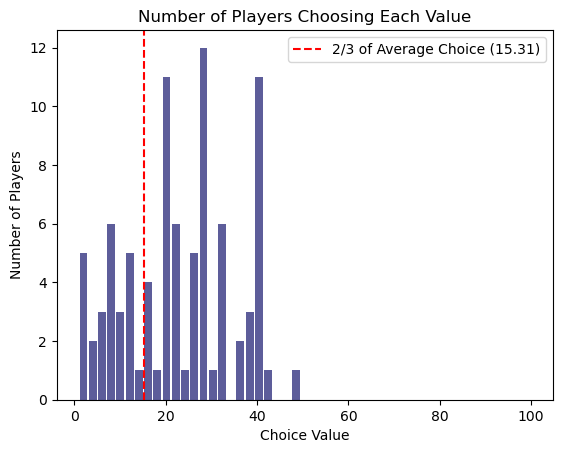

Maximum level of reasoning:  4
Average degree of the network:  0.0
Number of nodes in the network:  90


In [59]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

def belief_function(G, node):
    # Getting the outgoing neighbors (for directed graph)
    neighbors = list(G.successors(node))
    if not neighbors:
        # If no outgoing links, belief is a random number between 0 and node's level - 1
        return random.uniform(0, G.nodes[node]['level'] - 1)
    else:
        # The belief is the average level of the outgoing links
        return np.mean([G.nodes[neighbor]['level'] for neighbor in neighbors])


def choice_function(G, node, random_choice_prob):
    level = G.nodes[node]['level']
    # Randomly choose between a strategic choice and a completely random choice
    avg_belief = belief_function(G, node)
    if random.random() < random_choice_prob:
        # Almost random choice
        return random.uniform(1, ((2/3)**(avg_belief + 1)) * 60)
    else:
        # Strategic choice based on the average belief
        if level == 0:
            return random.uniform(1, 100)
        else:
            return ((2/3)**(avg_belief + 1)) * 60

def generate_directed_network(level_counts, p):
    G = nx.DiGraph()
    node_count = 0

    # Add nodes with their levels
    for level, count in enumerate(level_counts):
        for _ in range(count):
            G.add_node(node_count, level=level)
            node_count += 1

    # Connect nodes
    if p == 1:
        # In the case of p=1, connect each node in level k to all nodes in levels 0 to k-1
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for lower_level_node in G.nodes:
                if G.nodes[lower_level_node]['level'] < node_level:
                    G.add_edge(node, lower_level_node)
    elif p == 0:
        # In the case of p=0, return the graph with no edges
        pass
    else:
        # Calculate modified probability for other cases
        kappa = len(level_counts)
        p_hat = (p * (1 - p)) / (1 - p**(kappa - 1))

        # Connect nodes based on calculated probabilities
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for target_level in range(kappa):
                if node_level > target_level:
                    prob = (p_hat**(node_level - target_level)) * level_counts[target_level]
                    prob /= sum((p_hat**(node_level - k)) * level_counts[k] for k in range(node_level))
                    for target_node in G.nodes:
                        if G.nodes[target_node]['level'] == target_level and random.random() < prob:
                            G.add_edge(node, target_node)

    return G

def plot_choice_frequency(G):
    # Calculate choices for all nodes
    choices = [choice_function(G, node, random_choice_prob) for node in G.nodes]

    # Plotting the actual number of players choosing each value
    plt.hist(choices, bins=np.linspace(1, 100, 50), color='midnightblue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Choice Value')
    plt.ylabel('Number of Players')
    plt.title('Number of Players Choosing Each Value')

    # Marking the 2/3 of the average of all choices with a dashed line
    avg_choice = np.mean(choices)
    plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
    plt.legend()

    plt.savefig('k-level synthetic experiments-Game choices.png', dpi=600)
    plt.show()

# Example usage
level_counts = [10, 20, 20, 20, 20]  # Number of players in each level
p = 0
random_choice_prob = 0.5  # Probability of making a random choice
network = generate_directed_network(level_counts, p)

# Plot the choice frequency for the generated network
plot_choice_frequency(network)
print("Maximum level of reasoning: ", len(level_counts)-1)
print("Average degree of the network: ", network.number_of_edges()/network.number_of_nodes())
print("Number of nodes in the network: ", network.number_of_nodes())

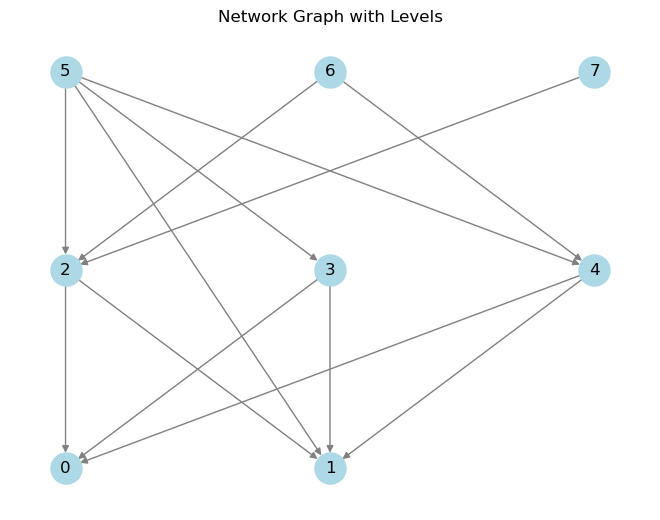

In [42]:
def plot_graph_with_levels(G):
    # Determine the number of levels
    levels = set(nx.get_node_attributes(G, 'level').values())
    max_level = max(levels) + 1

    # Create a position dictionary for each node
    pos = {}
    for level in range(max_level):
        nodes_at_level = [node for node, attr in G.nodes(data=True) if attr['level'] == level]
        level_pos = {node: (i, -level) for i, node in enumerate(nodes_at_level)}
        pos.update(level_pos)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title('Network Graph with Levels')
    plt.gca().invert_yaxis()  # Invert y-axis to have lower levels at the bottom
    plt.savefig('k-level synthetic experiments-Example Network.png', dpi=600)
    plt.show()

level_counts_plot = [2, 3, 3]  # Number of players in each level
p_plot = 0.5
network_plot = generate_directed_network(level_counts_plot, p_plot)

# Plotting the graph
plot_graph_with_levels(network_plot)


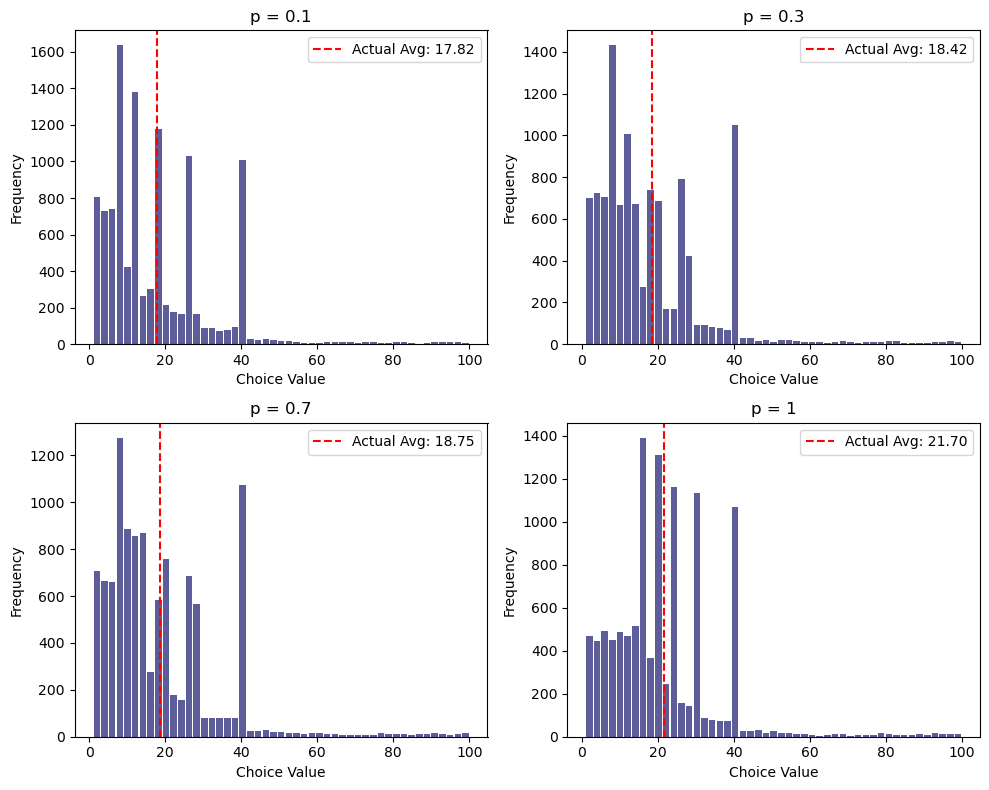

In [50]:
def average_choice_frequency_over_instances(level_counts, p, num_instances):
    all_choices = []

    for _ in range(num_instances):
        # Generate the network for each instance
        network = generate_directed_network(level_counts, p)

        # Calculate choices for all nodes in this instance
        choices = [choice_function(network, node, random_choice_prob) for node in network.nodes]
        all_choices.extend(choices)

    return all_choices

# Parameters
level_counts = [10, 20, 20, 20, 20, 20]  # Number of players in each level
p_values = [0.1, 0.3, 0.7, 1]  # Different probabilities to be tested
num_instances = 100  # Number of instances to average over

fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 subplot grid
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, p in enumerate(p_values):
    # Calculate the average choice frequency over multiple instances
    average_choices = average_choice_frequency_over_instances(level_counts, p, num_instances)

    # Calculate the actual average of all choices
    actual_avg_choice = np.mean(average_choices)

    # Plot the average choice frequency on the ith subplot
    axs[i].hist(average_choices, bins=np.linspace(1, 100, 50), color='midnightblue', alpha=0.7, rwidth=0.85)
    axs[i].axvline(actual_avg_choice, color='red', linestyle='--', label=f'Actual Avg: {actual_avg_choice:.2f}')
    axs[i].set_xlabel('Choice Value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'p = {p}')
    axs[i].legend()

plt.tight_layout()
plt.savefig('k-level synthetic experiments-Average choice frequency.png', dpi=600)
plt.show()